<a href="https://colab.research.google.com/github/orbenishay/Regression-Project/blob/Hagai/Amsterdam1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amsterdam Airbnb** 
https://www.kaggle.com/adityadeshpande23/amsterdam-airbnb

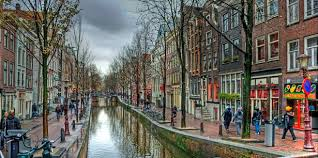


In [2]:

import pandas as pd # General tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings
from datetime import datetime # Pandas
from datetime import timedelta
from scipy.optimize import curve_fit# For curve fitting
from sklearn.base import TransformerMixin # For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator # For predictions
from sklearn.metrics import mean_squared_log_error as msle # For scoring
from sklearn.metrics import mean_squared_error as mse # For scoring
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import pydot as pyd # For the tree visualization
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split # For validation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
!pip install pydot;


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving Amsterdam1.csv to Amsterdam1.csv


In [4]:
bnb = pd.read_csv('Amsterdam1.csv', index_col='#')
bnb.head()

,latitude,longitude,d_centre,accommodates,bathrooms,bedrooms,calculated_host_listings_count,guests_included,host_listings_count,minimum_nights,number_of_reviews,instant_bookable,room_type,price
#,,,,,,,,,,,,,,
1,52.358466,4.933843,3.279483,4,2.0,2,1,1,1,2,8,Not Possible,Entire home/apt,160
2,52.363589,4.983353,5.951843,4,1.0,2,1,2,1,3,0,Not Possible,Entire home/apt,120
3,52.375209,4.861647,2.601055,2,1.0,1,1,1,1,3,8,Not Possible,Entire home/apt,99
4,52.387382,4.890457,1.095138,2,1.0,1,1,1,1,2,41,Not Possible,Private room,100
5,52.384062,4.889877,0.844491,2,1.0,1,1,1,1,3,0,Not Possible,Entire home/apt,175


## **Data Cleansing**

In [0]:
# DataFrame actions:
bnb = bnb[bnb.isnull().sum(axis=1)<3] # Remove rows with more than 3 `NaN`'s.
bnb = bnb.loc[:, ~bnb.columns.str.contains(r'facebook|num', case=False)] # remove specific columns
bnb.drop_duplicates(inplace=True) # Remove duplicates
bnb.drop_duplicates(subset=['director_name', 'title_year'], inplace=True) # Remove duplicates with subsets: Only consider certain columns for identifying duplicates, by default use all of the columns
bnb.index.value_counts().head() # look for duplications
bnb.loc['Ben-Hur'] # show all columns values for a specific row
bnb.loc[:,['imdb_score','budget']] # slice dataframe (show specific columns)
bnb[bnb.director_name.isin(good_directors)] # filter on column values
bnb.director_name.loc[:,].count() # count of entries in a column of a df
bnb.director_name.shape # dimention of df
bnb[['city','dock_count']].groupby('city').describe() # describe with subset

## **EDA**

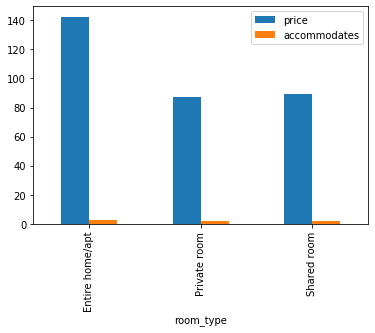

In [0]:
bnb.groupby('room_type').agg({'price': 'mean', 'accommodates': 'median'}).plot(kind='bar');


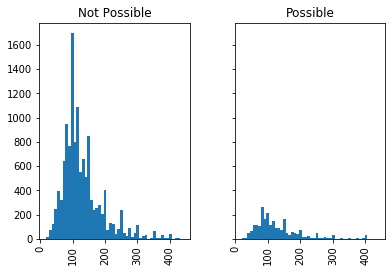

In [0]:
bnb.hist(column='price', by='instant_bookable', bins=50, sharex=True, sharey=True);

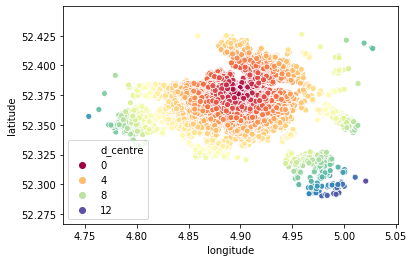

In [12]:
# ax = bnb.plot(kind = 'scatter',x='longitude',y='latitude', c='d_centre',colormap='viridis', figsize = (15, 10))

sns.scatterplot(x='longitude', y='latitude', hue='d_centre', data=bnb, palette="Spectral")

## **Outlier Removal**